In [55]:
import re
import unicodedata
import pandas as pd
import nltk

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


from env import username, password, host

def get_db_url(database, host=host, username=username, password=password):
    return f'mysql+pymysql://{username}:{password}@{host}/{database}'


url = get_db_url("spam_db")
sql = "SELECT * FROM spam"

df = pd.read_sql(sql, url, index_col="id")
df.head()


,label,text
id,,
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
# Returns the input word unchanged if it cannot be found in WordNet
nltk.stem.WordNetLemmatizer()

<WordNetLemmatizer>

In [75]:
# Pulling stopwords/little or no semantic meanings/ and additional stop words list below.
nltk.corpus.stopwords.words('english') + ["r", "u", "2", "ltgt"]

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [87]:
ham_words = unicodedata.normalize("NFKD"," ".join(df[df.label == 'ham'].text)).encode('ascii', "ignore").decode('utf-8', "ignore").lower()

In [88]:
spam_words = unicodedata.normalize("NFKD", " ".join(df[df.label == 'spam'].text)).encode('ascii', "ignore").decode('utf-8', "ignore").lower()

In [89]:
all_words = unicodedata.normalize("NFKD", " ".join(df.text)).encode("ascii", "ignore").decode('utf-8', "ignore").lower()

In [68]:
ham_words= re.sub(r'[^\w\s]', '', ham_words).split()

In [69]:
spam_words= re.sub(r'[^\w\s]', '', spam_words).split()

In [70]:
all_words= re.sub(r'[^\w\s]', '', all_words).split()

In [80]:
ADDITIONAL_STOPWORDS = ['r', 'u', '2', 'ltgt']

def clean(text):
    'A simple function to cleanup text data'
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]


In [90]:
ham_words= clean(ham_words)
spam_words= clean(spam_words)
all_words= clean(all_words)

In [91]:
ham_freq= pd.Series(ham_words).value_counts()

In [92]:
spam_freq = pd.Series(spam_words).value_counts()

In [93]:
all_freq = pd.Series(all_words).value_counts()

In [94]:
spam_freq.head()

call    359
free    216
txt     150
ur      144
text    137
dtype: int64

In [95]:
labels = pd.concat([df.label.value_counts(), df.label.value_counts(normalize=True)], axis=1)

In [96]:
labels.columns = ['n', 'percent']

In [97]:
labels

,n,percent
ham,4825,0.865937
spam,747,0.134063


In [98]:
word_counts = pd.concat([all_freq, ham_freq, spam_freq], axis=1, sort=True).set_axis(['all', 'ham', 'spam'], axis=1, inplace=False).fillna(0).apply(lambda s: s.astype(int))

In [99]:
word_counts.sort_values(by='all', ascending=False).head(10)

,all,ham,spam
call,600,241,359
im,462,449,13
get,397,314,83
ur,384,240,144
go,304,273,31
4,287,168,119
dont,279,257,22
ok,277,272,5
free,275,59,216
know,267,241,26


In [100]:
pd.concat([word_counts[word_counts.spam ==0].sort_values(by='ham').tail(6), word_counts[word_counts.ham ==0].sort_values(by='spam').tail(6)])

,all,ham,spam
thats,94,94,0
i_,117,117,0
say,118,118,0
da,132,132,0
later,134,134,0
lor,160,160,0
awarded,38,0,38
18,43,0,43
guaranteed,50,0,50
tone,73,0,73


<AxesSubplot: >

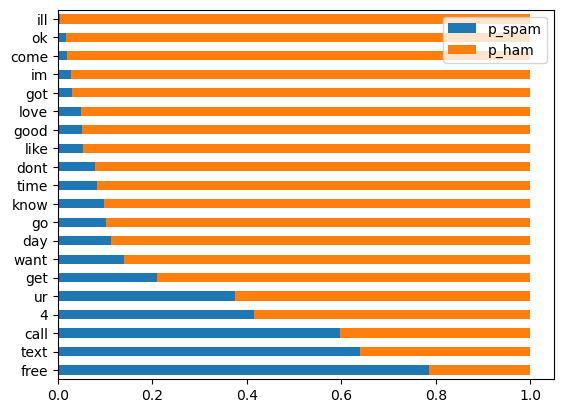

In [101]:
word_counts.assign(p_spam=word_counts.spam / word_counts['all'],
                   p_ham=word_counts.ham / word_counts['all']).sort_values(by='all')[['p_spam', 'p_ham']].tail(20).sort_values('p_ham').plot.barh(stacked=True)

In [102]:
word_counts[(word_counts.spam > 10) & 
            (word_counts.ham > 10)].assign(ratio=lambda df: df.spam
                                           /(df.ham +.01)).sort_values(by='ratio').pipe(lambda df: pd.concat([df.head(), 
                                                                                                              df.tail()]))

,all,ham,spam,ratio
im,462,449,13,0.028953
good,235,223,12,0.053809
like,245,232,13,0.056032
need,182,171,11,0.064324
dont,279,257,22,0.085600
contact,70,14,56,3.997145
win,76,15,61,4.063957
cash,74,12,62,5.162365
mobile,150,15,135,8.994004
txt,163,13,150,11.529593


In [103]:
from wordcloud import WordCloud

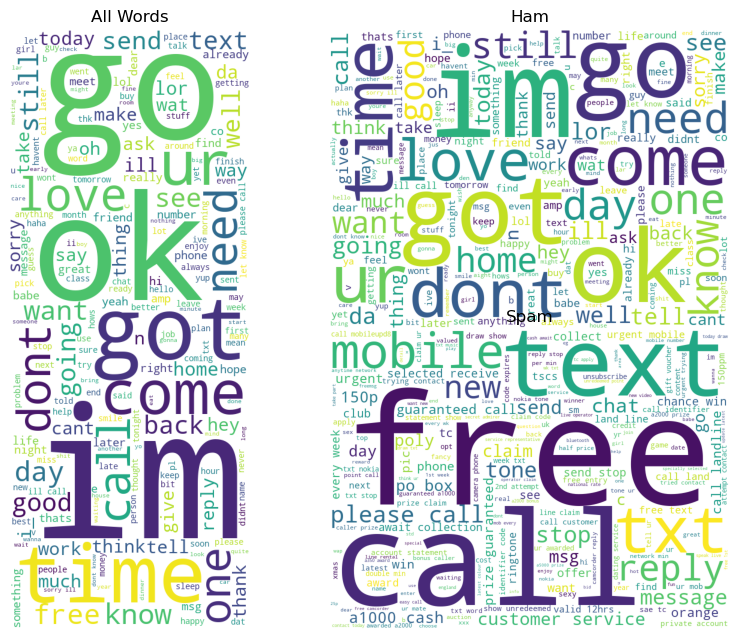

In [104]:
all_cloud= WordCloud(background_color='white', height=1000, width=400).generate(' '.join(all_words))
ham_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(ham_words))
spam_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(spam_words))

plt.figure(figsize=(8,6))
axs = [plt.axes([0, 0, .5, 1]), plt.axes([.5, .5, .5, .5]), plt.axes([.5, 0, .5, .5])]

axs[0].imshow(all_cloud)
axs[1].imshow(ham_cloud)
axs[2].imshow(spam_cloud)

axs[0].set_title('All Words')
axs[1].set_title('Ham')
axs[2].set_title('Spam')

for ax in axs: ax.axis('off')

In [106]:
bigrams = nltk.ngrams(.split(), 2)

AttributeError: 'list' object has no attribute 'split'